In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import umap
import datetime

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.tree import plot_tree

import statsmodels.api as sm

from scipy import stats

import gc

gc.collect()


318

In [19]:
def dump_metrics(model, preds, true, model_name, scores_df=None):
    precision = metrics.precision_score(true, preds, average="macro")
    recall = metrics.recall_score(true, preds, average="macro")
    accuracy = metrics.accuracy_score(true, preds)
    f1 = metrics.f1_score(true, preds, average="macro")

    if scores_df is not None:
        scores_df = pd.concat([scores_df, pd.DataFrame({
            "Name": model_name,
            "Precision" : precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "F1": f1
        }, index=[0])])

    else:
        scores_df = pd.DataFrame({
            "Name": model_name,
            "Precision" : precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "F1": f1
        }, index=[0])

    return scores_df

def save_model(model, model_name):
    with open(f"{model_name}.pickle", "wb") as out_file:
        pickle.dump(model, out_file)

def load_model(model_name):
    with open(f"{model_name}.pickle", "rb") as in_file:
        return pickle.load(in_file)

In [2]:
train_df = pd.read_csv("data/train.csv", index_col=0)
test_df = pd.read_csv("data/test.csv", index_col=0)
train_features = test_df.columns

In [3]:
x_train, x_val, y_train, y_val = train_test_split(train_df[train_features], train_df["Target"], test_size=0.2, stratify=train_df["Target"], random_state=0)

CPU times: total: 1.95 s
Wall time: 634 ms


Text(0.5, 1.0, 'Confusion Matrix: Logistic Classifier')

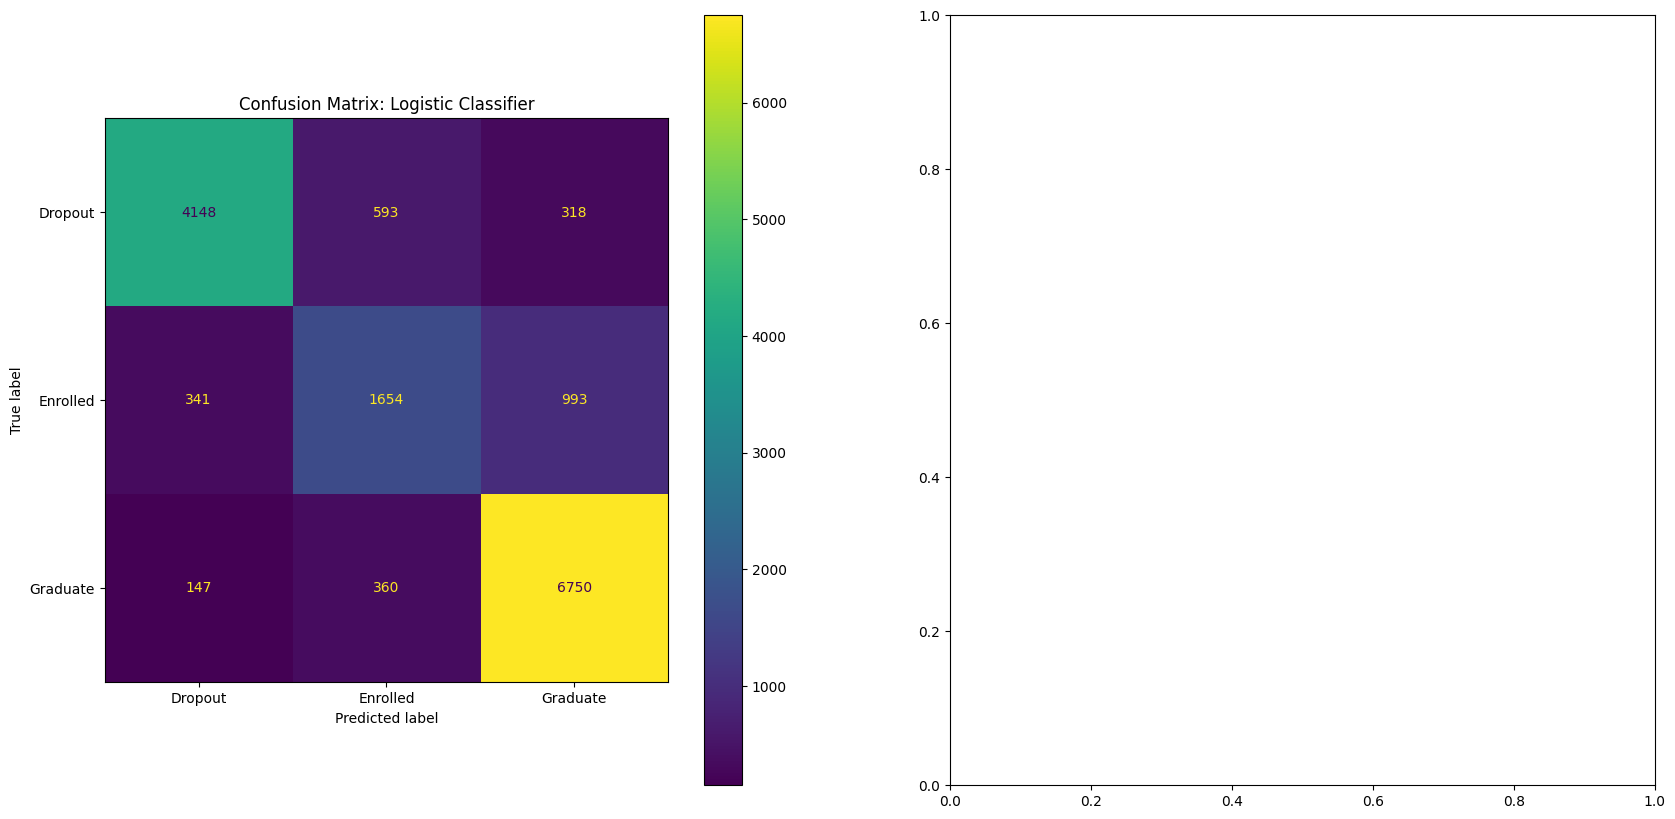

In [12]:
%%time

# force_retrain_logreg = False

# if force_retrain_logreg:
#     log_model = LogisticRegression(random_state=0)
    
#     pipe = Pipeline(steps=[
#         ("standardize", StandardScaler()),
#         ("feat_sel", RFE(log_model)),
#         ("model", log_model)
#     ])
    
#     cv_params = {
#         "feat_sel__n_features_to_select": np.arange(0, len(x_train.columns)),
#         "model__penalty": [None, "l2", "l1", "elasticnet"],
#         "model__solver" :['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#         # "model__max_iter" : np.arange(1000, 10000, 1000)
#     }
#     scoring = ['accuracy', 'precision', 'recall', 'f1']
    
#     log_cv = GridSearchCV(pipe, cv_params, scoring=scoring, refit='f1', verbose=1, n_jobs=-1, cv=2).fit(x_train, y_train)

#     save_model(log_cv, "tuned_feature_selected_LogReg")

# else:
#     log_cv = load_model("tuned_feature_selected_LogReg")

log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0)
)
log_model.fit(x_train, y_train)
log_preds = log_model.predict(x_val)

fig, ax = plt.subplots(1, 2, figsize=(20,10))

cm = metrics.confusion_matrix(y_val, log_preds, labels=log_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot(ax=ax[0])
ax[0].set_title("Confusion Matrix: Logistic Classifier")

# metrics.RocCurveDisplay.from_predictions(y_val, log_preds, ax=ax[1])
# ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
# ax[1].set_title("ROC: Logistic Classifier")

In [20]:
scores_df = dump_metrics(log_model, log_model.predict(x_train), y_train, "Logistic: Training")
scores_df = dump_metrics(log_model, log_preds, y_val, "Logistic: Testing", scores_df)

scores_df

,Name,Precision,Recall,Accuracy,F1
0,Logistic: Training,0.783947,0.765112,0.816317,0.772599
0,Logistic: Testing,0.788849,0.767870,0.820178,0.776086


In [51]:
feature_coefs = log_model.steps[1][1].coef_
class_order = log_model.steps[1][1].classes_
coef_names = x_train.columns.values

sp_rows = 3
sp_cols = 1
sp_ids = [(r, c) for r in range(1, sp_rows+1) for c in range(1, sp_cols+1)]
fig = make_subplots(rows=sp_rows, cols=sp_cols, subplot_titles=class_order)

for i, (sp, class_coefs) in enumerate(zip(sp_ids, feature_coefs)):
    fig.append_trace(
        go.Bar(
            x=coef_names,
            y=class_coefs,
            name=class_order[i]
        ),
        row=sp[0],
        col=sp[1],
    )
fig.update_yaxes(range=[-1,1])
fig.update_layout(height=1000, width=1800, title_text="Feature Coefficients per Class of Logistic Model",)
fig.show()
gc.collect()

1230

In [50]:
data = [
    go.Bar(
            x=coef_names,
            y=feature_coefs[0],
            name=class_order[0],
            # marker_color="rgb(0,0,255)",
            opacity=0.5
        ),
    go.Bar(
            x=coef_names,
            y=feature_coefs[2],
            name=class_order[2],
            # marker_color="rgb(0,255,0)",
            opacity=0.5
        )
]

layout = go.Layout(
    barmode='overlay',
    title="Coefs: Dropout vs Graduate"
)
fig = go.Figure(data=data, layout=layout)
fig.show()

Text(0.5, 1.0, 'Confusion Matrix: Random Forest Classifier')

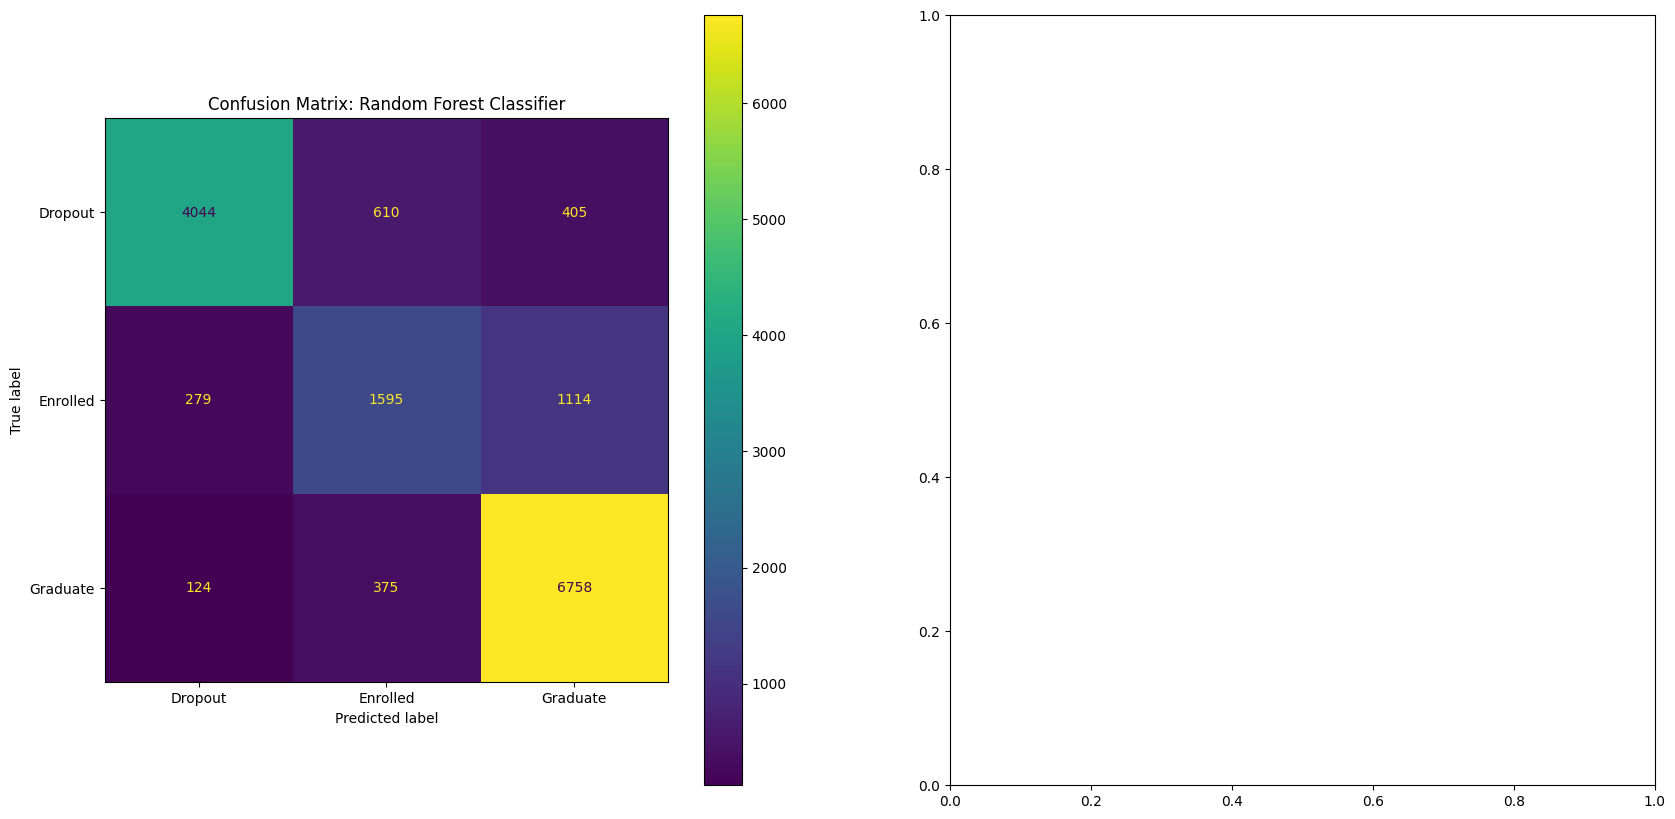

In [58]:
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=0, max_depth=5)
)
rf_model.fit(x_train, y_train)
rf_preds = rf_model.predict(x_val)

fig, ax = plt.subplots(1, 2, figsize=(20,10))

cm = metrics.confusion_matrix(y_val, rf_preds, labels=rf_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(ax=ax[0])
ax[0].set_title("Confusion Matrix: Random Forest Classifier")

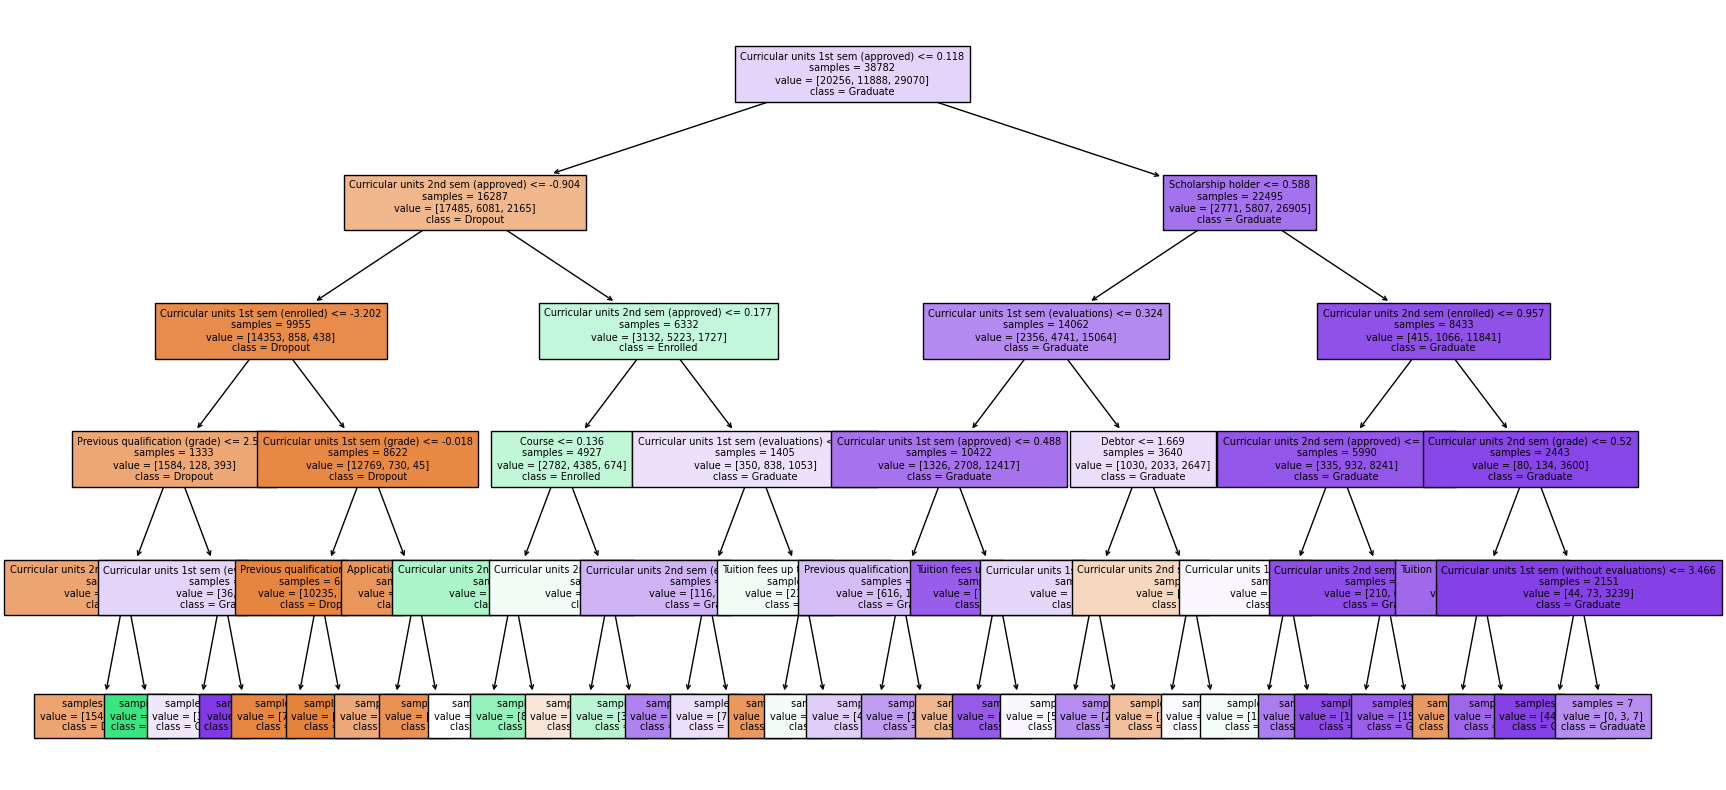

In [60]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model[1][1], feature_names=train_features, class_names=rf_model.classes_, fontsize=7, impurity=False, filled=True, ax=plt.gca())
plt.show()

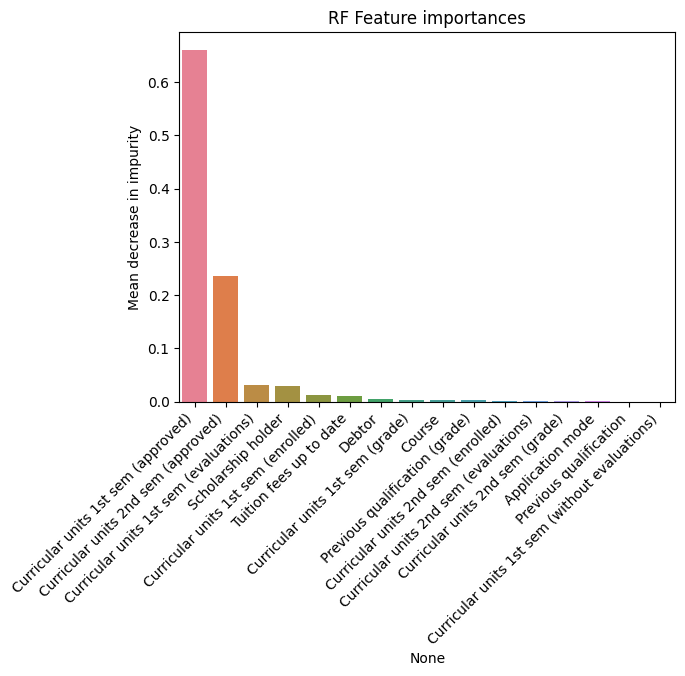

In [64]:
importances = rf_model[1][1].feature_importances_
rf_importances = pd.Series(importances, index=train_features)
rf_importances = rf_importances.sort_values(ascending=False)
rf_importances = rf_importances[rf_importances > 0]

sns.barplot(x=rf_importances.index, y=rf_importances.values, hue=rf_importances.index, legend=False)
plt.title('RF Feature importances')
plt.ylabel('Mean decrease in impurity')
plt.xticks(rotation=45, ha="right")
plt.show()